<a href="https://colab.research.google.com/github/Marcusleeleelee/Other_ML-DL-practice/blob/main/IERG4160_In_Class_Lab_Network_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IERG4160

Lecture 10: Neural network training practice

This is also the assignment 3. Please complete this colab and:

* Download it as .ipynb file (click on file -> download -> download as .ipynb file)
* Submit .ipynb file to blackboard

**To get started:**

1. Make a copy of this colab

2. Please download images from this folder and upload them to your Google Dirve:

https://drive.google.com/drive/folders/14SNI0FRWIZnIO7eFHAtKRJFHodxq0OU8?usp=drive_link

**Disclaimer**

This tutorial comes from


https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

https://stackoverflow.com/questions/47432168/taking-subsets-of-a-pytorch-dataset

https://blog.csdn.net/qq_39753950/article/details/125743543

https://github.com/selva86/datasets/blob/master/BostonHousing.csv

**Preparation**

Similar to assignment 1, please make a copy of the following folder to your own Google drive.

https://drive.google.com/drive/folders/14SNI0FRWIZnIO7eFHAtKRJFHodxq0OU8?usp=sharing

# Section 0: Setup

**Requirement**: No thing to complete in this section. However, you need to run all the blocks in this section to get your colab ready.

If your job restarts, just rerun it.

In [44]:
#@title Import all necessary libraries

# General python library
import os
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.animation as animation

# Torch library
import torch
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor

# Colab
from google.colab import drive

In [45]:
#@title Useful functions

def load_image(filename):
  im_pil = Image.open(os.path.join(srcpath, filename))
  im = np.array(im_pil).astype(np.float32) / 255
  return im

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

**Note:** Update the `srcpath` below to the right path on your Google Drive.

In [46]:
#@title At last, mount your colab

drive.mount('/content/drive')
srcpath = 'yoyoyoyo'  #@param {type:'string'}
srcpath = os.path.join('/content/drive/My Drive', srcpath)
print('srcpath = ', srcpath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
srcpath =  /content/drive/My Drive/yoyoyoyo


# Section 1: Tutorial for basic python operations

**Requirement**: No thing to complete in this section. This is just some examples to teach you how to use python, numpy, and torch.

We would also suggest to you read tutorial 1 carefully.





Operate numpy array

In [47]:
# Create an array
a = np.ones((3, 4), np.float32)  # Create 3x4, float32 array

# Modify an array
a[1, 2] = 0

# Print an array
print('######')
print('a = ')
print(a)

# Print array size
print('######')
print('a.shape = ')
print(a.shape)

######
a = 
[[1. 1. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 1.]]
######
a.shape = 
(3, 4)


Operate torch tensor (array)

In [48]:
# Create an array
a = torch.ones((3, 4), dtype=torch.float32)  # Create 3x4, float32 array

# Print an array
print('######')
print('a = ')
print(a)

# Print array size
print('######')
print('a.shape = ')
print(a.shape)

######
a = 
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
######
a.shape = 
torch.Size([3, 4])


Load and visualize an image

#####
im.shape = (height, width, height)
(512, 512, 3)


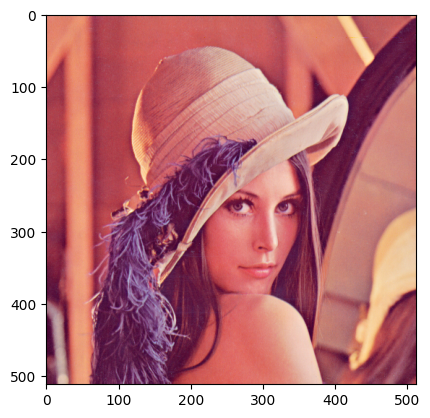

In [49]:
# Load image lenna
im = load_image('lenna.png')

# Print image size
print('#####')
print('im.shape = (height, width, height)')
print(im.shape)

# Visualize image lenna
_ = plt.imshow(im)

Visualize multiple images

Text(0.5, 1.0, 'Blue')

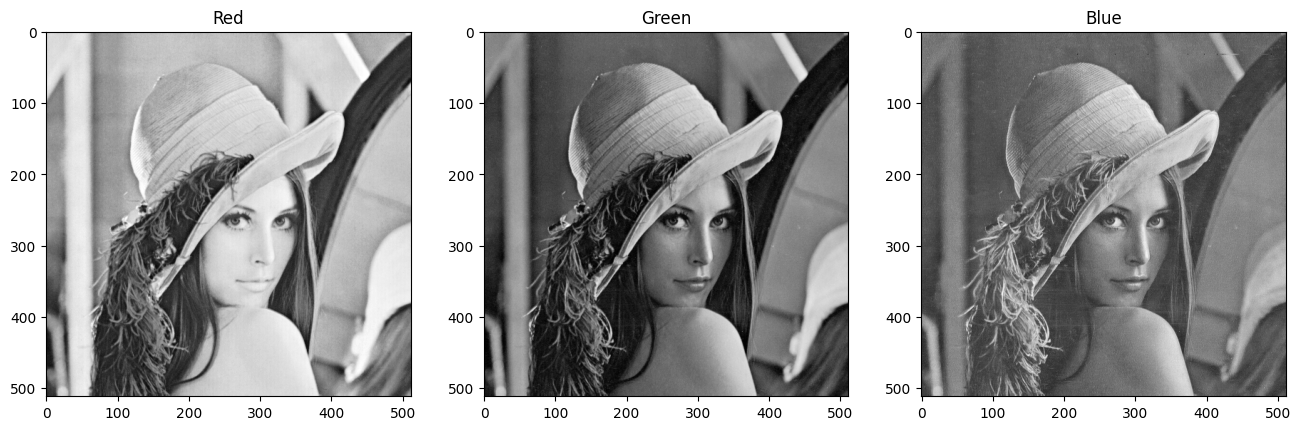

In [50]:
# Create a figure with size 16x6
plt.figure(figsize=(16, 5))

# plt.subplot(1, 3, 1) means that we will create 1x3 sub figures and next we will show the 1st sub figure.
plt.subplot(1, 3, 1); plt.imshow(im[..., 0], cmap='gray'); plt.title('Red')

# plt.subplot(1, 3, 2) means that we will use 1x3 sub figures and next we will show the 2nd sub figure.
plt.subplot(1, 3, 2); plt.imshow(im[..., 1], cmap='gray'); plt.title('Green')

# 3rd sub figure.
plt.subplot(1, 3, 3); plt.imshow(im[..., 2], cmap='gray'); plt.title('Blue')

# Section 2: Prepare dataset for training

**Requirement**: No thing to complete in this section. However, if you need to run section 3 and 4, you need to run this blocks first.

Recall that to train a network, we need:

* **Networks**. Network contains unknown parameters.
* **Dataset**. It includes both:
  + A training set: on this dataset, we optimize the network parameters, which is called training.
  + a test set: on this dataset, we evaluate whether performance of the network.
* **Loss function**. A evaluation metric (loss) we want to minimize.
* **Optimization method**. A method to minimize the loss function.

Let us define: **dataset** and **loss** this section. **network** and **loss** will be defined in the next section.

## 2.1. Load the **dataset**.

Here we use MNIST dataset, which is a digital recognition dataset. If you want to know more details, please check:

https://en.wikipedia.org/wiki/MNIST_database

This block may take about 10-20 seconds to download the dataset.

In [52]:
#@title Load the MNIST dataset

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Create data loaders.
batch_size = 64    #@param {type:"integer"}
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Let us check how the shape of input and output. The input is 28x28 single channel image. The output is a single class label, whose value is 0-9 (10 possible values).

Each time we load an image, we actually load a batch, and first dimension is the batch size. Please refer to Lecture Note 7, Slide 69 for the definition of a batch.

In [53]:
#@title Print shapes of the input image and the output label

# Note that this channel order in torch is slightly different from slides.

for input_image, _ in test_dataloader:
    print(f"Shape of input image: [Number of images in a batch, No. of channel, Height, Width]: {input_image.shape}")
    break

Shape of input image: [Number of images in a batch, No. of channel, Height, Width]: torch.Size([64, 1, 28, 28])


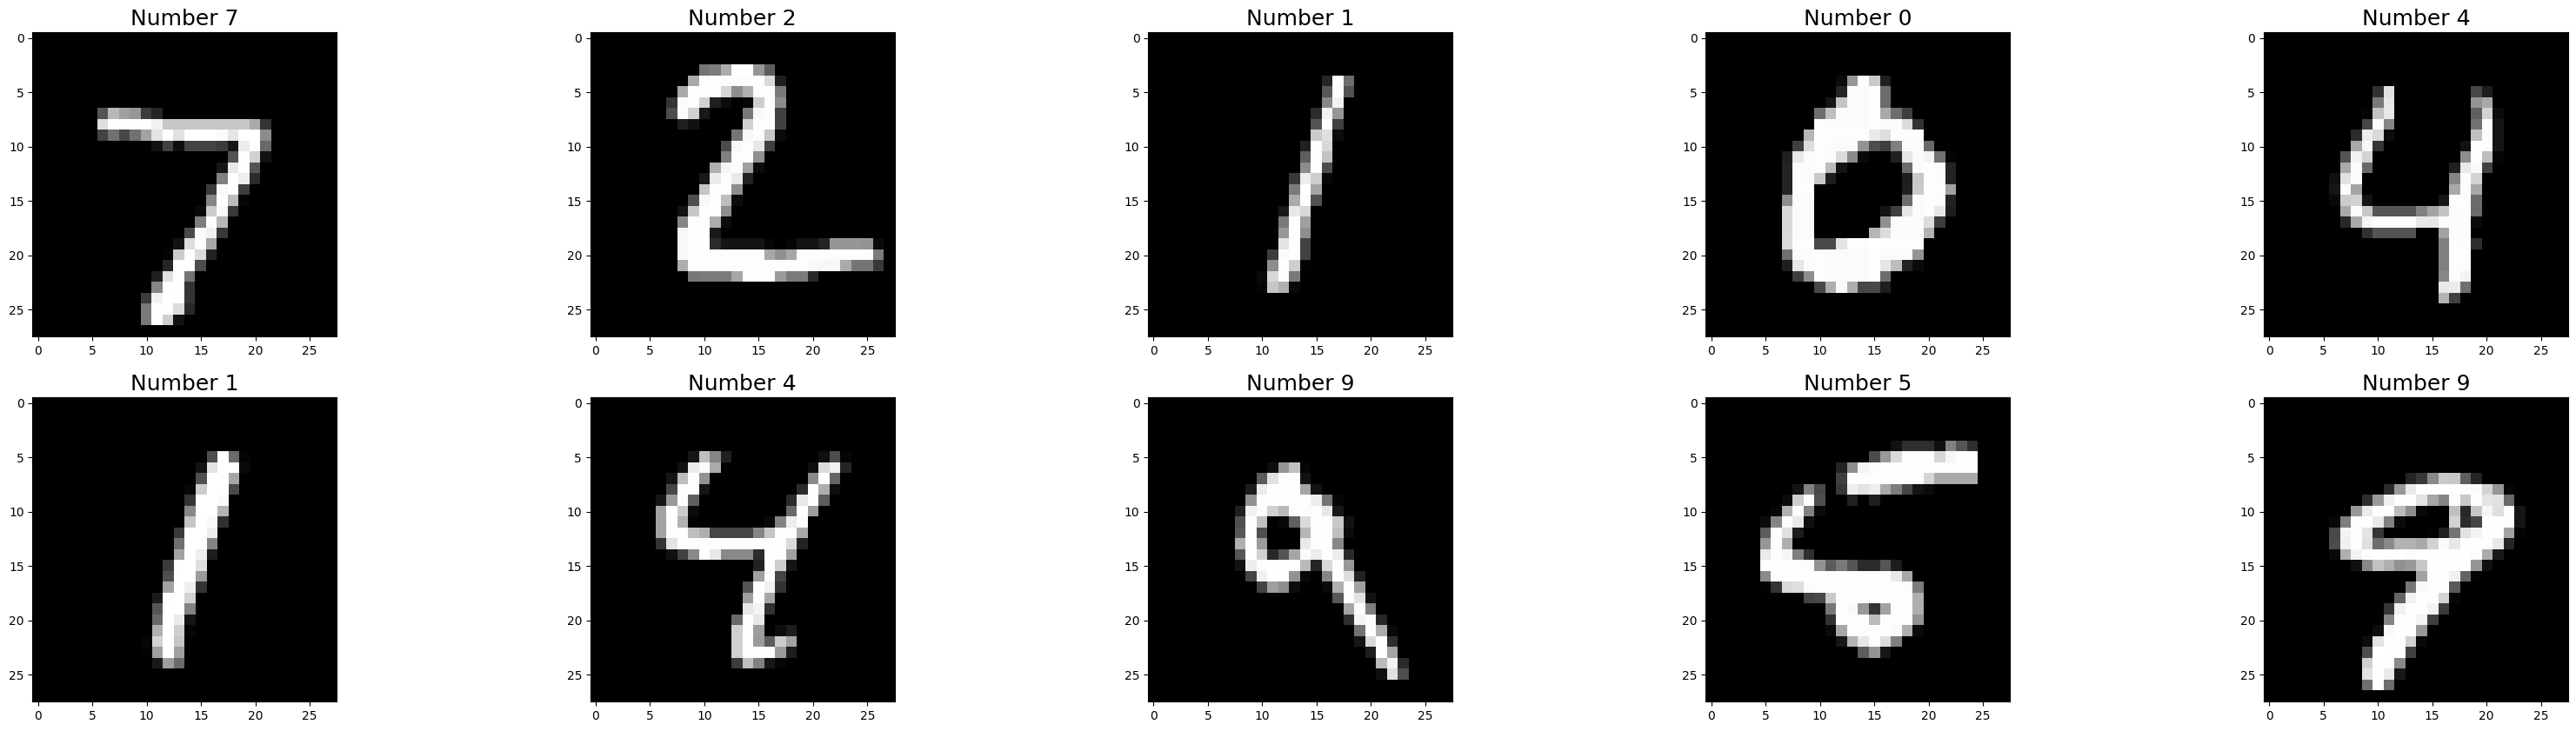

In [54]:
#@title Visualize the training 10 samples

plt.figure(figsize=(40, 10))
for input_image, ground_truth_label in test_dataloader:
  for i in range(10):
      plt.subplot(2, 5, i + 1)
      plt.imshow(input_image[i, 0, ...], cmap='gray')
      label_i = int(ground_truth_label[i])
      plt.title(f'Number {label_i}', fontsize=18)
  break

## 2.2. Define **loss**

In [55]:
#@title Define **loss**

loss_fn = nn.CrossEntropyLoss()

In [56]:
#@title Also setup a training device.

device = 'cpu'  # For this tutorial, cpu is enough. For more efficient training, you could GPU ('cuda'). However, you need to purchase GPU hours if you want to do so.

# Section 3: Define network and run training

**Requirement**: Please run 3.1-3.3 and fill missing code in 3.4.

**Note, please pay special attention to the block we highlighted below.**

In [57]:
#@title 3.1. Define the network

class NeuralNetwork1(nn.Module):
    def __init__(self):
        super().__init__()
        #################################################################
        ### This block is very important. Make sure you understand it ###
        self.network = nn.Sequential(
            nn.Flatten(),             # This flatten image, which converts 28x28 image to 756 vector
            nn.Linear(28*28, 128),    # nn.Linear(a, b) means the input is a channels and the output is b chnnals
            nn.Linear(128, 128),      # Similarly, this is 128-channel input and 128-channel output.
            nn.Linear(128, 10)        # Since the output is 10-class, so the output must be 10 channels.
        )
        #################################################################

    def forward(self, x):
        return self.network(x)

In [58]:
#@title 3.2. Define the optimizer

model_1 = NeuralNetwork1().to(device)
learning_rate = 1e-1          # Check Lecture note 7, Slide 63 for the definition of learning rate
optimizer = torch.optim.SGD(model_1.parameters(), lr=learning_rate)

**Please run the 3.3, and check the result.** It may take up to 30 seconds.

In [59]:
#@title 3.3. Finally, we can run training.

# For each epoch, we first run training to update the parameters, and run test to check the accuracy
# Please refer to Lecture Note 7, slide 74 for details of `epoch`.

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_1, loss_fn, optimizer)
    test(test_dataloader, model_1, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.321301  [   64/60000]
loss: 0.467993  [ 6464/60000]
loss: 0.360419  [12864/60000]
loss: 0.412006  [19264/60000]
loss: 0.256893  [25664/60000]
loss: 0.368596  [32064/60000]
loss: 0.281799  [38464/60000]
loss: 0.362126  [44864/60000]
loss: 0.414940  [51264/60000]
loss: 0.455402  [57664/60000]
Test Error: 
 Accuracy: 90.7%, Avg loss: 0.324863 

Done!


The accuracy should be about 90%.

**Please run missing code in 3.4, and check the result.**

In [60]:
#@title 3.4. Please fill this one. Run **another** 2 epochs.

# Your code goes here
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_1, loss_fn, optimizer)
    test(test_dataloader, model_1, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.180785  [   64/60000]
loss: 0.265327  [ 6464/60000]
loss: 0.188395  [12864/60000]
loss: 0.350504  [19264/60000]
loss: 0.225122  [25664/60000]
loss: 0.358879  [32064/60000]
loss: 0.247627  [38464/60000]
loss: 0.351140  [44864/60000]
loss: 0.371944  [51264/60000]
loss: 0.421848  [57664/60000]
Test Error: 
 Accuracy: 90.7%, Avg loss: 0.315179 

Epoch 2
-------------------------------
loss: 0.156063  [   64/60000]
loss: 0.260585  [ 6464/60000]
loss: 0.170097  [12864/60000]
loss: 0.338293  [19264/60000]
loss: 0.218126  [25664/60000]
loss: 0.358144  [32064/60000]
loss: 0.229722  [38464/60000]
loss: 0.344081  [44864/60000]
loss: 0.351177  [51264/60000]
loss: 0.411313  [57664/60000]
Test Error: 
 Accuracy: 91.0%, Avg loss: 0.311662 

Done!


The accuracy should not change too much in these 2 epochs.

# Section 4. Update network structure

**Requirement**: Please complete the section 4.1 and run 4.2.

If you check closely, you may find that it miss some ReLU in the previous definition. Please try fix that in 4.1.

**Hint:** Please check the Lecture Note 7, slide 38.

**Hint:** The ReLU layer is defined as nn.ReLU(). For example, if you want to add a ReLU layer to first two linear layers, it looks like:

nn.Sequential(
...,
nn.Linear(28*28, 128),
nn.ReLU(),
nn.Linear(128, 128),
...
)


In [64]:
#@title 4.1. Define the network.

class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        #################################################################
        # Your code goes here.
        #################################################################
        self.network = nn.Sequential(
            nn.Flatten(),             # This flatten image, which converts 28x28 image to 756 vector
            nn.Linear(28*28, 128),    # nn.Linear(a, b) means the input is a channels and the output is b chnnals
            nn.ReLU(),
            nn.Linear(128, 128),      # Similarly, this is 128-channel input and 128-channel output.
            nn.ReLU(),
            nn.Linear(128, 10),       # Since the output is 10-class, so the output must be 10 channels.
            # nn.ReLU(),
        )

    def forward(self, x):
        return self.network(x)

In [65]:
#@title 4.2. Run training

model_2 = NeuralNetwork2().to(device)
learning_rate = 1e-1
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate)
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_2, loss_fn, optimizer)
    test(test_dataloader, model_2, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.291271  [   64/60000]
loss: 0.764661  [ 6464/60000]
loss: 0.407178  [12864/60000]
loss: 0.426984  [19264/60000]
loss: 0.272063  [25664/60000]
loss: 0.337701  [32064/60000]
loss: 0.217734  [38464/60000]
loss: 0.302064  [44864/60000]
loss: 0.297784  [51264/60000]
loss: 0.300801  [57664/60000]
Test Error: 
 Accuracy: 92.9%, Avg loss: 0.233559 

Epoch 2
-------------------------------
loss: 0.145438  [   64/60000]
loss: 0.194595  [ 6464/60000]
loss: 0.121475  [12864/60000]
loss: 0.289731  [19264/60000]
loss: 0.130873  [25664/60000]
loss: 0.249798  [32064/60000]
loss: 0.128453  [38464/60000]
loss: 0.230667  [44864/60000]
loss: 0.177842  [51264/60000]
loss: 0.205291  [57664/60000]
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.162902 

Epoch 3
-------------------------------
loss: 0.097933  [   64/60000]
loss: 0.143750  [ 6464/60000]
loss: 0.101786  [12864/60000]
loss: 0.210979  [19264/60000]
loss: 0.089074  [25664/60000]
loss: 0.201102  [32064/600

**Note:** After run training, the test accuracy should be >95%. If it is much lower, it means that your code may have some issues.

# Section 5. Run the trained network on a new image.

**Requirement**: Please complete the section 5.3 and 5.4.

## 5.1 Load a testing image.

(28, 28)


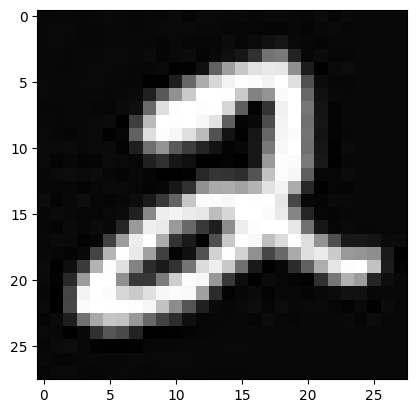

In [66]:
test_image = 1.0 - cv2.cvtColor(load_image('2.jpg'), cv2.COLOR_RGB2GRAY)
plt.imshow(test_image, cmap='gray')
print(test_image.shape)

## 5.2 Run the trained network.

In [67]:
test_image_torch = torch.Tensor(test_image[np.newaxis, np.newaxis])
model_2.eval()
predicted_torch = model_2(test_image_torch)
predicted = predicted_torch.detach().numpy()[0, ...]
print('The predicted label is:', predicted)

The predicted label is: [-1.6235832  -1.6976883  11.586676    6.740371   -4.746945   -2.0550745
 -7.444182   -0.27331293  2.8045058  -3.4163377 ]


## 5.3 Convert predicted one-hot vector to actual label

In [71]:
label =  int(np.where(np.max(predicted) == predicted)[0])# Your code goes here
print(label)

2


<ipython-input-71-7affa0593464>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label =  int(np.where(np.max(predicted) == predicted)[0])# Your code goes here


## 5.4 [Bonus] Try it on your own image

Draw an hard-written digit using Windows paint, or other drawing software, upload this image to Google drive, and test the trained network.

To finish that, please use plt.imshow to show your testing image, and also print the final result.

If your image is not 28x28, try to use cv.resize to change the resolution.

You may need to repeat 5.1-5.3.

In [72]:
### Your code goes here.
# Repeat Step 5.1:
test_image = 1.0 - cv2.cvtColor(load_image('3.jpg'), cv2.COLOR_RGB2GRAY)
plt.imshow(test_image, cmap='gray')
print(test_image.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/yoyoyoyo/3.jpg'

# Section 6. Try CNN

## 6.1. Define network

**Requirement**: Please fix an error in 6.1 and run 6.2.

Here we deliberately make in the highlighted line below. Please try to fix it.

**Hint:** Try to calculate the image resolution by filling ? in the comment may help you.

In [ ]:
#@title Define network

class NeuralNetwork3(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                                 # A convolutional network
                                                 # After this layer, the image is 28x28 with 32 channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                  # nn.MaxPool2d(2, 2) is a 2x2 pooling layer
                                                 # After this layer, the image is 14x14 with 32 channels
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                                 # After this layer, the image is still 14x14 with 32 channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                  # After this layer, the image is ?x? with 32 channels
            nn.Flatten(),
        #################################################################
        # This line has a bug, please fix it.
            nn.Linear(14*14*32, 10)   # Here we assume that input is 14x14 image with 32 channel, but this is actually wrong. Please fix it.
        #################################################################
        )

    def forward(self, x):
        return self.network(x)

## 6.2 Run training.

This training is slower. May take 1-3 minutes.

In [ ]:
#@title Run training

model_3 = NeuralNetwork3().to(device)
learning_rate = 1e-1
optimizer = torch.optim.SGD(model_3.parameters(), lr=learning_rate)
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_3, loss_fn, optimizer)
    test(test_dataloader, model_3, loss_fn)
print("Done!")

If your code is correct, the accuracy should be >97%.

## 6.3 [bonus] Visualize intermediate layers

First, let us visualize the network. Note that there 8 layers.

In [ ]:
print(model_3)

Let us run testing on an image. This time, we manually run each layer

In [ ]:
test_image = 1.0 - cv2.cvtColor(load_image('2.jpg'), cv2.COLOR_RGB2GRAY)
test_image_torch = torch.Tensor(test_image[np.newaxis, np.newaxis])
layer_output = test_image_torch

model_3.eval()
for i in range(8):
  layer_output = model_3.network[i](layer_output)
print(layer_output)

tensor([[-0.5379, -0.2242, 10.3012,  3.8032, -1.0158, -4.6468, -6.2046,  0.7337,
          1.2672, -3.0211]], grad_fn=<AddmmBackward0>)


**Question**:  Visualize the first 4-channels of the 1st convolutional layer. You may need to change the block above.

In [ ]:
# Your code goes here

plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1); plt.imshow()
plt.subplot(1, 4, 2); plt.imshow()
plt.subplot(1, 4, 3); plt.imshow()
plt.subplot(1, 4, 4); plt.imshow()

**Question**:  Visualize the first 4-channels of the 2nd convolutional layer

In [ ]:
# Your code goes here